# Get data

In [ ]:
# To run this notebook, follow the next steps:
# 1. You need to download the archive.zip file from https://www.kaggle.com/datasets/sonainjamil/bleached-corals-detection
# 2. Create a folder named 'Bleached_and_Unbleached_Corals_Classification/' inside the 'raw_data' folder
# 3. Copy the archive.zip file into the 'Bleached_and_Unbleached_Corals_Classification/' folder
# 4. Define the 'path_data' variable below with the path to the 'raw_data/Bleached_and_Unbleached_Corals_Classification/' folder on your local machine.

# path_data = '/Users/carloschutz/code/Lucia-Cordero/ReefSight-Project/raw_data/Bleached_and_Unbleached_Corals_Classification'

In [7]:
import os
import tensorflow as tf

data_dir = "/Users/carloschutz/code/Lucia-Cordero/ReefSight-Project/raw_data/Bleached_and_Unbleached_Corals_Classification:"

print("Contents of data_dir:", os.listdir(data_dir))
# Expect: ['Bleached', 'Unbleached'] (order may vary) (if showing other files, check the path or delete extraneous files)


Contents of data_dir: ['.DS_Store', 'Bleached', 'Unbleached']


In [8]:
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="binary",
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="binary",
)

class_names = train_ds.class_names
print("Classes:", class_names)  # Expect: ['Bleached', 'Unbleached'] (order may vary)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


Found 342 files belonging to 2 classes.
Using 274 files for training.
Found 342 files belonging to 2 classes.
Using 68 files for validation.
Classes: ['Bleached', 'Unbleached']


In [9]:
import tensorflow as tf
from tensorflow.keras import layers

image_size = (224, 224)
input_shape = image_size + (3,)
learning_rate = 1e-4
num_classes = 2

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

def create_vgg16_model(input_shape, learning_rate=1e-4):
    inputs = layers.Input(shape=input_shape)

    x = data_augmentation(inputs)
    x = preprocess_input(x)

    base_model = VGG16(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )
    base_model.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

vgg_model = create_vgg16_model(input_shape, learning_rate)
vgg_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ add_1[0][0]       │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(data_dir, "models", "vgg16_best.keras"),
        monitor="val_accuracy",
        save_best_only=True
    ),
]

history = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
)


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5401 - loss: 1.6009 - val_accuracy: 0.5735 - val_loss: 1.1921
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5912 - loss: 1.1904 - val_accuracy: 0.6912 - val_loss: 0.9665
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6314 - loss: 1.1986 - val_accuracy: 0.7353 - val_loss: 0.7325
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.6460 - loss: 1.0691 - val_accuracy: 0.7500 - val_loss: 0.5543
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.7263 - loss: 0.7399 - val_accuracy: 0.7941 - val_loss: 0.4757
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7774 - loss: 0.6156 - val_accuracy: 0.7941 - val_loss: 0.4358
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7920 - loss: 0.6018 - val_accuracy: 0.8235 - val_loss: 0.4109
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8102 - loss: 0.5457 - val_accuracy: 0.8676 - val_loss: 0.3449
Epoch 9/

In [11]:
val_loss, val_acc = vgg_model.evaluate(val_ds)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9706 - loss: 0.0979
Validation loss: 0.09794193506240845
Validation accuracy: 0.970588207244873


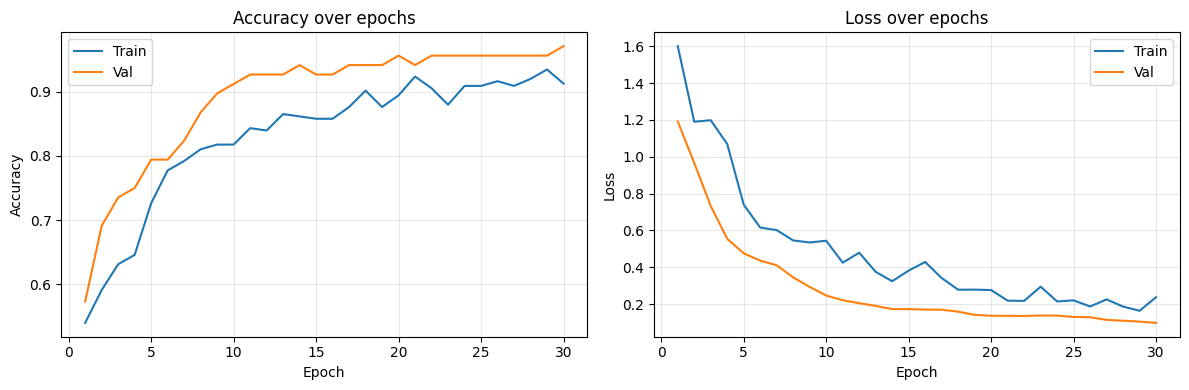

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    # Put history into a DataFrame for easier plotting
    df = pd.DataFrame(history.history)
    df["epoch"] = range(1, len(df) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(df["epoch"], df["accuracy"], label="Train")
    plt.plot(df["epoch"], df["val_accuracy"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over epochs")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(df["epoch"], df["loss"], label="Train")
    plt.plot(df["epoch"], df["val_loss"], label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


/var/folders/pd/49tggkj16kj_jxk0fmm8f0b00000gn/T/ipykernel_95952/1545908713.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[idx].numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
True: Bleached
Pred: Bleached
Bleached probability: 98.04%
Unbleached probability: 1.96%


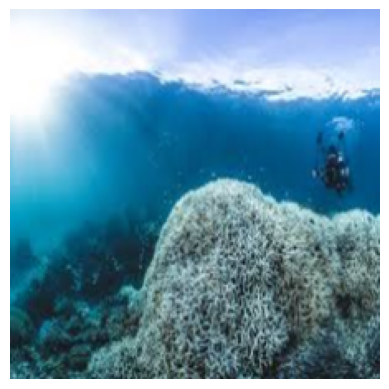

In [13]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os

best_model_path = os.path.join(data_dir, "models", "vgg16_best.keras")
model = tf.keras.models.load_model(best_model_path)


if 'class_names' not in globals():
    if hasattr(train_ds, "class_names"):
        class_names = train_ds.class_names
    else:
        class_names = sorted(
            [entry.name for entry in os.scandir(data_dir) if entry.is_dir()]
        )


images, labels = next(iter(val_ds))
idx = random.randint(0, len(images) - 1)
img = images[idx]
true_label = int(labels[idx].numpy())

prob = float(model.predict(tf.expand_dims(img, 0))[0, 0])  # P(class 1)
pred_label = int(prob >= 0.5)


bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1
unbleached_idx = 1 - bleached_idx

if bleached_idx == 1:
    p_bleached = prob
else:
    p_bleached = 1 - prob

print("True:", class_names[true_label])
print("Pred:", class_names[pred_label])
print(f"Bleached probability: {p_bleached*100:.2f}%")
print(f"Unbleached probability: {(1 - p_bleached)*100:.2f}%")

plt.imshow(img.numpy().astype("uint8"))
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
True: Bleached
Pred: Bleached
Bleached probability: 86.74%
Unbleached probability: 13.26%


/var/folders/pd/49tggkj16kj_jxk0fmm8f0b00000gn/T/ipykernel_95952/1545908713.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[idx].numpy())


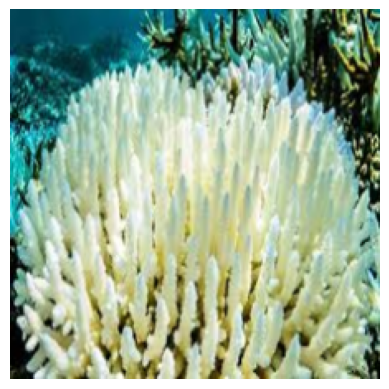

In [14]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os

best_model_path = os.path.join(data_dir, "models", "vgg16_best.keras")
model = tf.keras.models.load_model(best_model_path)


if 'class_names' not in globals():
    if hasattr(train_ds, "class_names"):
        class_names = train_ds.class_names
    else:
        class_names = sorted(
            [entry.name for entry in os.scandir(data_dir) if entry.is_dir()]
        )


images, labels = next(iter(val_ds))
idx = random.randint(0, len(images) - 1)
img = images[idx]
true_label = int(labels[idx].numpy())

prob = float(model.predict(tf.expand_dims(img, 0))[0, 0])  # P(class 1)
pred_label = int(prob >= 0.5)


bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1
unbleached_idx = 1 - bleached_idx

if bleached_idx == 1:
    p_bleached = prob
else:
    p_bleached = 1 - prob

print("True:", class_names[true_label])
print("Pred:", class_names[pred_label])
print(f"Bleached probability: {p_bleached*100:.2f}%")
print(f"Unbleached probability: {(1 - p_bleached)*100:.2f}%")

plt.imshow(img.numpy().astype("uint8"))
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
True: Bleached
Pred: Bleached
Bleached probability: 98.38%
Unbleached probability: 1.62%


/var/folders/pd/49tggkj16kj_jxk0fmm8f0b00000gn/T/ipykernel_95952/1545908713.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[idx].numpy())


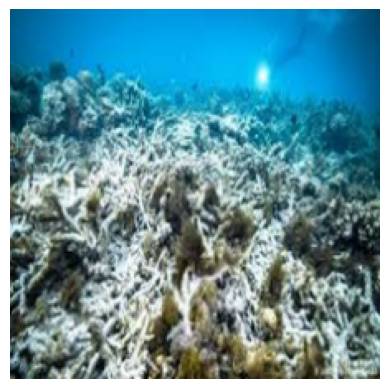

In [15]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os

best_model_path = os.path.join(data_dir, "models", "vgg16_best.keras")
model = tf.keras.models.load_model(best_model_path)


if 'class_names' not in globals():
    if hasattr(train_ds, "class_names"):
        class_names = train_ds.class_names
    else:
        class_names = sorted(
            [entry.name for entry in os.scandir(data_dir) if entry.is_dir()]
        )


images, labels = next(iter(val_ds))
idx = random.randint(0, len(images) - 1)
img = images[idx]
true_label = int(labels[idx].numpy())

prob = float(model.predict(tf.expand_dims(img, 0))[0, 0])  # P(class 1)
pred_label = int(prob >= 0.5)


bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1
unbleached_idx = 1 - bleached_idx

if bleached_idx == 1:
    p_bleached = prob
else:
    p_bleached = 1 - prob

print("True:", class_names[true_label])
print("Pred:", class_names[pred_label])
print(f"Bleached probability: {p_bleached*100:.2f}%")
print(f"Unbleached probability: {(1 - p_bleached)*100:.2f}%")

plt.imshow(img.numpy().astype("uint8"))
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
True: Unbleached
Pred: Unbleached
Bleached probability: 0.00%
Unbleached probability: 100.00%


/var/folders/pd/49tggkj16kj_jxk0fmm8f0b00000gn/T/ipykernel_95952/1545908713.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[idx].numpy())


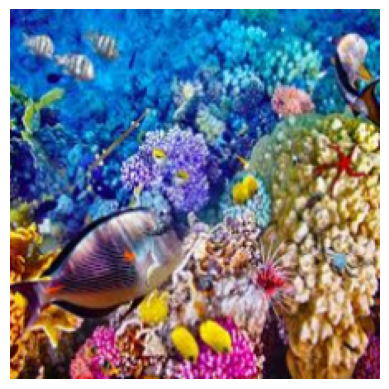

In [16]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os

best_model_path = os.path.join(data_dir, "models", "vgg16_best.keras")
model = tf.keras.models.load_model(best_model_path)


if 'class_names' not in globals():
    if hasattr(train_ds, "class_names"):
        class_names = train_ds.class_names
    else:
        class_names = sorted(
            [entry.name for entry in os.scandir(data_dir) if entry.is_dir()]
        )


images, labels = next(iter(val_ds))
idx = random.randint(0, len(images) - 1)
img = images[idx]
true_label = int(labels[idx].numpy())

prob = float(model.predict(tf.expand_dims(img, 0))[0, 0])  # P(class 1)
pred_label = int(prob >= 0.5)


bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1
unbleached_idx = 1 - bleached_idx

if bleached_idx == 1:
    p_bleached = prob
else:
    p_bleached = 1 - prob

print("True:", class_names[true_label])
print("Pred:", class_names[pred_label])
print(f"Bleached probability: {p_bleached*100:.2f}%")
print(f"Unbleached probability: {(1 - p_bleached)*100:.2f}%")

plt.imshow(img.numpy().astype("uint8"))
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
True: Unbleached
Pred: Unbleached
Bleached probability: 0.98%
Unbleached probability: 99.02%


/var/folders/pd/49tggkj16kj_jxk0fmm8f0b00000gn/T/ipykernel_95952/1545908713.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[idx].numpy())


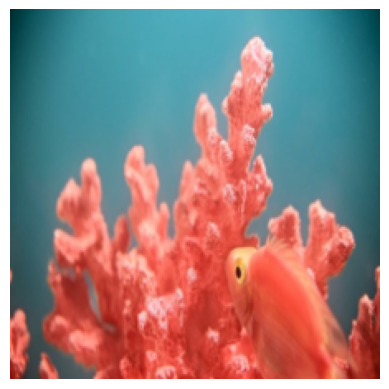

In [17]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os

best_model_path = os.path.join(data_dir, "models", "vgg16_best.keras")
model = tf.keras.models.load_model(best_model_path)


if 'class_names' not in globals():
    if hasattr(train_ds, "class_names"):
        class_names = train_ds.class_names
    else:
        class_names = sorted(
            [entry.name for entry in os.scandir(data_dir) if entry.is_dir()]
        )


images, labels = next(iter(val_ds))
idx = random.randint(0, len(images) - 1)
img = images[idx]
true_label = int(labels[idx].numpy())

prob = float(model.predict(tf.expand_dims(img, 0))[0, 0])  # P(class 1)
pred_label = int(prob >= 0.5)


bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1
unbleached_idx = 1 - bleached_idx

if bleached_idx == 1:
    p_bleached = prob
else:
    p_bleached = 1 - prob

print("True:", class_names[true_label])
print("Pred:", class_names[pred_label])
print(f"Bleached probability: {p_bleached*100:.2f}%")
print(f"Unbleached probability: {(1 - p_bleached)*100:.2f}%")

plt.imshow(img.numpy().astype("uint8"))
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
True: Bleached
Pred: Bleached
Bleached probability: 95.27%
Unbleached probability: 4.73%


/var/folders/pd/49tggkj16kj_jxk0fmm8f0b00000gn/T/ipykernel_52813/72907917.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[idx].numpy())


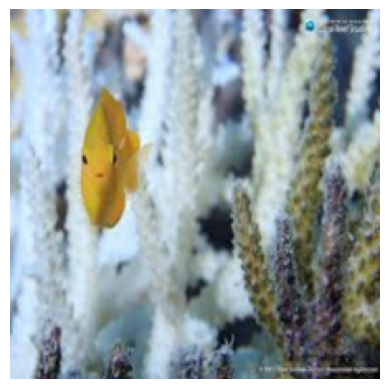

In [ ]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os

best_model_path = os.path.join(data_dir, "models", "vgg16_best.keras")
model = tf.keras.models.load_model(best_model_path)


if 'class_names' not in globals():
    if hasattr(train_ds, "class_names"):
        class_names = train_ds.class_names
    else:
        class_names = sorted(
            [entry.name for entry in os.scandir(data_dir) if entry.is_dir()]
        )


images, labels = next(iter(val_ds))
idx = random.randint(0, len(images) - 1)
img = images[idx]
true_label = int(labels[idx].numpy())

prob = float(model.predict(tf.expand_dims(img, 0))[0, 0])  # P(class 1)
pred_label = int(prob >= 0.5)


bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1
unbleached_idx = 1 - bleached_idx

if bleached_idx == 1:
    p_bleached = prob
else:
    p_bleached = 1 - prob

print("True:", class_names[true_label])
print("Pred:", class_names[pred_label])
print(f"Bleached probability: {p_bleached*100:.2f}%")
print(f"Unbleached probability: {(1 - p_bleached)*100:.2f}%")

plt.imshow(img.numpy().astype("uint8"))
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
True: Bleached
Pred: Bleached
Bleached probability: 99.99%
Unbleached probability: 0.01%


/var/folders/pd/49tggkj16kj_jxk0fmm8f0b00000gn/T/ipykernel_52813/1545908713.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(labels[idx].numpy())


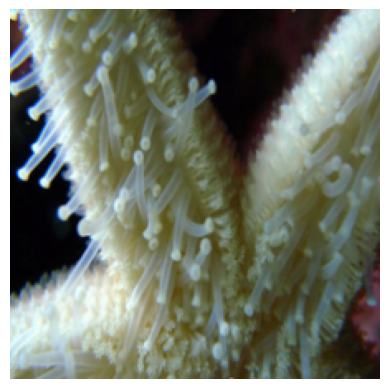

In [125]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import os

best_model_path = os.path.join(data_dir, "models", "vgg16_best.keras")
model = tf.keras.models.load_model(best_model_path)


if 'class_names' not in globals():
    if hasattr(train_ds, "class_names"):
        class_names = train_ds.class_names
    else:
        class_names = sorted(
            [entry.name for entry in os.scandir(data_dir) if entry.is_dir()]
        )


images, labels = next(iter(val_ds))
idx = random.randint(0, len(images) - 1)
img = images[idx]
true_label = int(labels[idx].numpy())

prob = float(model.predict(tf.expand_dims(img, 0))[0, 0])  # P(class 1)
pred_label = int(prob >= 0.5)


bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1
unbleached_idx = 1 - bleached_idx

if bleached_idx == 1:
    p_bleached = prob
else:
    p_bleached = 1 - prob

print("True:", class_names[true_label])
print("Pred:", class_names[pred_label])
print(f"Bleached probability: {p_bleached*100:.2f}%")
print(f"Unbleached probability: {(1 - p_bleached)*100:.2f}%")

plt.imshow(img.numpy().astype("uint8"))
plt.axis("off")
plt.show()


# For applying filter


In [130]:
pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 86.2 MB/s  0:00:004.7 MB/s eta 0:00:010:01
Note: you may need to restart the kernel to use updated packages.


In [140]:
import cv2
import numpy as np

def strong_channel_stretch(img_bgr):
    # img_bgr: uint8 BGR
    result = img_bgr.copy().astype(np.float32)
    for c in range(3):
        ch = result[:, :, c]
        min_val, max_val = np.percentile(ch, 1), np.percentile(ch, 99)  # clip extremes
        ch = (ch - min_val) * 255.0 / (max_val - min_val + 1e-8)
        ch = np.clip(ch, 0, 255)
        result[:, :, c] = ch
    return result.astype(np.uint8)


In [141]:
def load_and_correct(img_path, target_size=(224, 224)):
    bgr = cv2.imread(img_path)
    bgr = cv2.resize(bgr, target_size)

    # Stronger correction
    bgr_corr = strong_channel_stretch(bgr)

    rgb_corr = cv2.cvtColor(bgr_corr, cv2.COLOR_BGR2RGB)
    x = tf.keras.preprocessing.image.img_to_array(rgb_corr)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x, rgb_corr


In [142]:
def gray_world_then_stretch(img_bgr):
    # Step 1: gray‑world balance
    gw = img_bgr.astype(np.float32)
    b_avg, g_avg, r_avg = [np.mean(gw[:, :, c]) for c in range(3)]
    k = (b_avg + g_avg + r_avg) / 3.0
    gw[:, :, 0] *= k / (b_avg + 1e-8)
    gw[:, :, 1] *= k / (g_avg + 1e-8)
    gw[:, :, 2] *= k / (r_avg + 1e-8)
    gw = np.clip(gw, 0, 255).astype(np.uint8)

    # Step 2: per‑channel stretch
    return strong_channel_stretch(gw)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Predicted class: Unbleached
Bleached probability: 0.60%
Unbleached probability: 99.40%


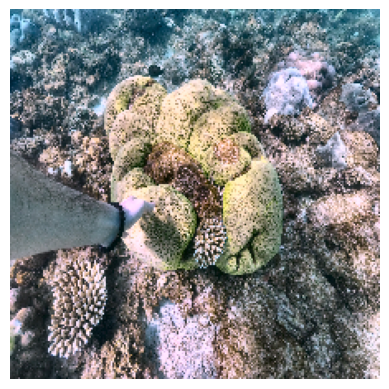

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# 1. Your color-correction function (unchanged)
def correct_underwater_color(image_bgr):
    """
    Gray World white balance + CLAHE contrast on BGR image.
    """
    B, G, R = cv2.split(image_bgr)

    avg_R = np.mean(R)
    avg_G = np.mean(G)
    avg_B = np.mean(B)
    avg_intensity = (avg_R + avg_G + avg_B) / 3.0

    gain_R = avg_intensity / (avg_R + 1e-8)
    gain_G = avg_intensity / (avg_G + 1e-8)
    gain_B = avg_intensity / (avg_B + 1e-8)

    R_corrected = np.clip(R * gain_R, 0, 255).astype(np.uint8)
    G_corrected = np.clip(G * gain_G, 0, 255).astype(np.uint8)
    B_corrected = np.clip(B * gain_B, 0, 255).astype(np.uint8)

    color_balanced_img = cv2.merge([B_corrected, G_corrected, R_corrected])

    # LAB + CLAHE for local contrast
    lab = cv2.cvtColor(color_balanced_img, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L_corrected = clahe.apply(L)

    lab_corrected = cv2.merge([L_corrected, a, b])
    final_corrected_img = cv2.cvtColor(lab_corrected, cv2.COLOR_LAB2BGR)

    return final_corrected_img

# 2. Helper to load, correct and prepare for your VGG16 model
def load_correct_and_prepare(img_path, target_size=(224, 224)):
    # Load BGR with OpenCV
    bgr = cv2.imread(img_path)
    if bgr is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    bgr = cv2.resize(bgr, target_size)

    # Apply underwater correction
    bgr_corr = correct_underwater_color(bgr)

    # Convert to RGB for visualization / Keras
    rgb_corr = cv2.cvtColor(bgr_corr, cv2.COLOR_BGR2RGB)

    # To array and preprocess for VGG16
    x = image.img_to_array(rgb_corr)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x, rgb_corr

# 3. Use your already loaded model and class_names
# model = tf.keras.models.load_model(best_model_path)
# class_names = ['Bleached', 'Unbleached']  # or from train_ds.class_names

img_path = "/Users/carloschutz/code/Lucia-Cordero/ReefSight-Project/raw_data/Bleached_and_Unbleached_Corals_Classification:/Bleached/R0251.JPG"  # <- change this

x, vis_img = load_correct_and_prepare(img_path)
prob = float(model.predict(x)[0, 0])  # sigmoid output
pred_label = int(prob >= 0.5)

# Map bleached probability correctly
bleached_idx = class_names.index("Bleached") if "Bleached" in class_names else 1
if bleached_idx == 1:
    p_bleached = prob
else:
    p_bleached = 1 - prob

print("Predicted class:", class_names[pred_label])
print(f"Bleached probability: {p_bleached*100:.2f}%")
print(f"Unbleached probability: {(1 - p_bleached)*100:.2f}%")

plt.imshow(vis_img)
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
True: Bleached
Pred: Bleached
Bleached probability: 95.27%
Unbleached probability: 4.73%


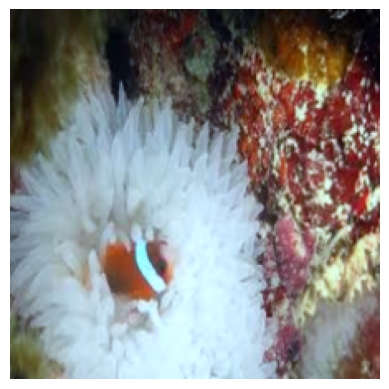

In [139]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

def load_and_correct(img_path, target_size=(224, 224)):
    # Load with OpenCV (BGR)
    bgr = cv2.imread(img_path)
    bgr = cv2.resize(bgr, target_size)

    # Color correction
    bgr_corr = simple_white_balance(bgr)

    # Convert to RGB for Keras
    rgb_corr = cv2.cvtColor(bgr_corr, cv2.COLOR_BGR2RGB)

    # To array for model
    x = image.img_to_array(rgb_corr)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # same as you used with VGG16
    return x, rgb_corr

x, vis_img = load_and_correct("/Users/carloschutz/code/Lucia-Cordero/ReefSight-Project/raw_data/Bleached_and_Unbleached_Corals_Classification:/Bleached/214.png")
prob = model.predict(x)[0, 0]
pred_label = int(prob >= 0.5)

print("True:", class_names[true_label])
print("Pred:", class_names[pred_label])
print(f"Bleached probability: {p_bleached*100:.2f}%")
print(f"Unbleached probability: {(1 - p_bleached)*100:.2f}%")

plt.imshow(vis_img)
plt.axis("off")
plt.show()
